In [24]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import FastText
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.neighbors import NearestNeighbors
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv('Questions.csv', encoding = "ISO-8859-1", nrows=30000, usecols=['Id', 'Title', 'Body'])

In [5]:
df.head()

,Id,Title,Body
0,469,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [7]:
df.shape

(30000, 3)

In [13]:
#Let's take a look at some of the questions
print('Question1: ', df.iloc[0, 2])
print('Question2: ', df.iloc[1, 2])
print('Question3: ', df.iloc[2, 2])

Question1:  <p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>

<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>

<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>

<ul>
<li>Some Photoshop javascript</li>
<li>A Python function</li>
<li>An OSX API that I can call from python</li>
</ul>

Question2:  <p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>

<p>On the Mac I am spawning <a href="http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html">sips</a>.  Is there something similarly simple I can do on Windows?</p>

Question3:  <p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending 

In [14]:
#Using beautiful soup to grab text inside 'p' tags and concatenate it
def get_question(html_text):
  soup = BeautifulSoup(html_text, 'lxml')
  question = ' '.join([t.text for t in soup.find_all('p')]) #concatenating all p tags
  return question

#Transforming questions to list for ease of processing
question_list = df['Body'].apply(get_question).values.tolist()

In [15]:
question_list[0]

"I am using the Photoshop's javascript API to find the fonts in a given PSD. Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc. This is all happening in a python program running on OSX so I guess I'm looking for one of:"

In [17]:
#Tokenizing with simple preprocess gensim's simple preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) # returns lowercase tokens, ignoring tokens that are too short or too long

question_words = list(sent_to_words(question_list))

In [21]:
question_words[0][0:5] #first 5 question tokens

['am', 'using', 'the', 'photoshop', 'javascript']

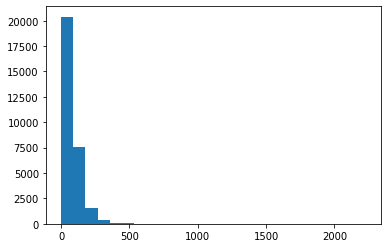

Mean word count of questions is 80.7959


In [22]:
lengths = [len(question) for question in question_words]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [25]:
#Getting rid of stopwords
stop_words = stopwords.words('english')

def remove_stopwords(sentence):
  filtered_words = [word for word in sentence if word not in stop_words]
  return filtered_words

filtered_questions = [remove_stopwords(question) for question in question_words]

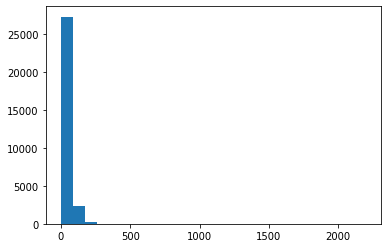

Mean word count of questions is 43.86006666666667


In [26]:
#Examining word counts after removal of stop words

lengths = [len(question) for question in filtered_questions]
plt.hist(lengths, bins = 25)
plt.show()

print('Mean word count of questions is %s' % np.mean(lengths))

In [27]:
len(filtered_questions)

30000

In [29]:
ft_model = gensim.models.Word2Vec(
    filtered_questions,
    min_count=1,
    compute_loss=True,
    hs=0,
    sg=1,
    seed=42,
)

In [30]:
print('Words similar to "array" are: ', ft_model.wv.most_similar('array'))
print('Words similar to "database" are: ', ft_model.wv.most_similar('database'))

Words similar to "array" are:  [('arrays', 0.8630626201629639), ('dimension', 0.8126401305198669), ('vector', 0.8099209070205688), ('matrix', 0.8012974262237549), ('zeros', 0.7910740375518799), ('slice', 0.7906018495559692), ('fft', 0.7897478938102722), ('dtype', 0.7859339714050293), ('recarray', 0.7800589799880981), ('transpose', 0.7760628461837769)]
Words similar to "database" are:  [('db', 0.8324282169342041), ('postgres', 0.7933104038238525), ('alchemy', 0.7879529595375061), ('databases', 0.786896288394928), ('sqlobject', 0.7784776091575623), ('postgresql', 0.7756752967834473), ('bulk', 0.7746185064315796), ('dbs', 0.7738659381866455), ('mssql', 0.7603881359100342), ('querying', 0.7553769946098328)]


Sentence Embedding
As a first approach, I will be using a so called centroid method to dervie the sentence embeddings (taken from this research paper http://www2.aueb.gr/users/ion/docs/BioNLP_2016.pdf). It derives sentence embeddings as the sum of individual word embeddings in a sentece weighted by their tf-idf score, and divided by the sum of these tf-idf scores

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(question_list)
print(X.shape)

(30000, 46433)


In [34]:
#To proprely work with scikit's vectorizer
merged_questions = [' '.join(question) for question in filtered_questions]
document_names = ['Doc {:d}'.format(i) for i in range(len(merged_questions))]

def get_tfidf(docs, ngram_range=(1,1), index=None):
    vect = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    tfidf = vect.fit_transform(docs).todense()
    return pd.DataFrame(tfidf, columns=vect.get_feature_names(), index=index).T

tfidf = get_tfidf(merged_questions, ngram_range=(1,1), index=document_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
n = 100
def get_sent_embs(emb_model):
    sent_embs = []
    for desc in range(len(filtered_questions)):
        sent_emb = np.zeros((1, n))
        if len(filtered_questions[desc]) > 0:
            sent_emb = np.zeros((1, n))
            div = 0
            model = emb_model
            for word in filtered_questions[desc]:
                if word in model.wv.vocab and word in tfidf.index:
                    word_emb = model.wv[word]
                    weight = tfidf.loc[word, 'Doc {:d}'.format(desc)]
                    sent_emb = np.add(sent_emb, word_emb * weight)
                    div += weight
                else:
                    div += 1e-13 #to avoid dividing by 0
        if div == 0:
            print(desc)

        sent_emb = np.divide(sent_emb, div)
        sent_embs.append(sent_emb.flatten())
    return sent_embs

In [40]:
ft_sent = get_sent_embs(emb_model = ft_model) 

In [41]:
def get_n_most_similar(interest_index, embeddings, n):
    """
    Takes the embedding vector of interest, the list with all embeddings, and the number of similar questions to 
    retrieve.
    Outputs the disctionary IDs and distances
    """
    nbrs = NearestNeighbors(n_neighbors=n, metric='cosine').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    similar_indices = indices[interest_index][1:]
    similar_distances = distances[interest_index][1:]
    return similar_indices, similar_distances

def print_similar(interest_index, embeddings, n):
    """
    Convenience function for visual analysis
    """
    closest_ind, closest_dist = get_n_most_similar(interest_index, embeddings, n)
    print('Question %s \n \n is most similar to these %s questions: \n' % (question_list[interest_index], n))
    for question in closest_ind:
        print('ID ', question, ': ',question_list[question])

In [42]:
print_similar(42, ft_sent, 5)

Question What's the best way to sanitise user input for a Python-based web application? Is there a single function to remove HTML characters and any other necessary characters combinations to prevent an XSS or SQL injection attack? 
 
 is most similar to these 5 questions: 

ID  7431 :  I'm trying to slowly knock out all of the intricacies of python.  Basically, I'm looking for some way, in python, to take a string of characters and push them all over by 'x' characters.   For example, inputing abcdefg will give me cdefghi (if x is 2).
ID  18347 :  I'm writing a Python extension that runs through a Py_UNICODE array, finds specific (ASCII, if it matters) characters, i.e. '\' or '\n', and does some additional stuff for each one that it finds. Is there a way to write those characters as literals?  If not, what is the correct way to obtain Py_UNICODEs for them, keeping in mind that Py_UNICODE's size and internal representation may differ from system to system?
ID  15742 :  Despite offering 